In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2

2022-02-03 14:50:24.638243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-03 14:50:24.638273: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# img_path = 'img_st/1.png'
img_path = '/home/a/Documents/grad_cam/african_elephant.jpg'

# model = tf.keras.models.load_model('es_func_folder_224x3_c.h5')
# model = tf.keras.applications.VGG16()
# preprocess_input = tf.keras.applications.vgg16.preprocess_input
# IMG_SIZE = (224, 224)

# model = tf.keras.applications.EfficientNetB7()
# preprocess_input = tf.keras.applications.efficientnet.preprocess_input
# IMG_SIZE = (600, 600)

model = tf.keras.applications.MobileNetV2()
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SIZE = (224,224)

2022-02-03 14:50:26.653873: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-03 14:50:26.653912: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a): /proc/driver/nvidia/version does not exist
2022-02-03 14:50:26.654205: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
img = Image.open(img_path).resize(IMG_SIZE, Image.ANTIALIAS).convert('RGB')
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)  # for pretrained
# img = np.array(img)/255   # for MNIST

In [4]:
def gradcam_viz(model, image):
    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D)
    )

    grad_model = tf.keras.Model(
        [model.inputs], [last_conv_layer.output, model.output]
    )

    pred = model.predict(img)
    pred = np.argmax(pred[0])

    with tf.GradientTape() as tape:
        last_conv_out, prediction = grad_model(img)
        loss = prediction[:, pred]

    grads = tape.gradient(loss, last_conv_out)  

    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    last_conv_out = last_conv_out[0]

    heatmap = last_conv_out @ pooled_grads[..., tf.newaxis]

    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    plt.imshow(heatmap.numpy(), cmap='gray')

2022-02-03 14:50:28.181820: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-03 14:50:29.243103: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19418112 exceeds 10% of free system memory.
2022-02-03 14:50:29.251275: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19418112 exceeds 10% of free system memory.
2022-02-03 14:50:29.258852: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18364416 exceeds 10% of free system memory.
2022-02-03 14:50:29.265071: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 21073920 exceeds 10% of free system memory.
2022-02-03 14:50:29.271304: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 21073920 exceeds 10% of free system memory.


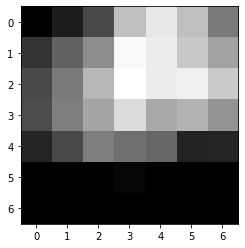

In [5]:
gradcam_viz(model, img)